In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.amp import autocast, GradScaler
import os
import random

In [2]:
cutoff       = 20
batch_size   = 64

# creation/annihilation operators
a      = torch.diag(torch.sqrt(torch.arange(1, cutoff, dtype=torch.float32)), 1).to(torch.complex64)
a_dag  = a.T.conj()

def displacement_cpu(alpha):
    if not torch.is_tensor(alpha):
        alpha = torch.tensor(alpha, dtype=torch.complex64)
    G = alpha * a_dag - alpha.conj() * a
    return torch.linalg.matrix_exp(G)

def squeezing_cpu(z):
    if not torch.is_tensor(z):
        z = torch.tensor(z, dtype=torch.complex64)
    G = 0.5 * (z.conj() * (a @ a) - z * (a_dag @ a_dag))
    return torch.linalg.matrix_exp(G)

def snap(theta):
    """SNAP gate: diag(e^{i theta_n}). theta: real vector length=cutoff."""
    return torch.diag(torch.exp(1j * theta.to(torch.complex64)))

def displacement(alpha):
    """Batched displacement D(alpha) = exp(alpha a^† - alpha* a)."""
    device = alpha.device
    a_dev, ad_dev = a.to(device), a_dag.to(device)
    B = alpha.shape[0]
    α = alpha.view(B,1,1)
    return torch.linalg.matrix_exp(α * ad_dev - α.conj() * a_dev)



In [3]:
class SnapDispLayer(nn.Module):
    def __init__(self, cutoff, depth):
        super().__init__()
        self.cutoff = cutoff
        self.depth  = depth
        self.register_buffer('a',     a)
        self.register_buffer('a_dag', a_dag)
        # quadrature operator x = (a + a^†)/2
        x_op = (a + a_dag) / 2
        self.register_buffer('x_op', x_op)
        # variational parameters
        self.alpha_r = nn.Parameter(torch.randn(depth) * 0.01)
        self.alpha_i = nn.Parameter(torch.randn(depth) * 0.01)
        self.thetas  = nn.Parameter(torch.rand(depth, cutoff) * 2 * np.pi)

    def forward_state(self, state):
        B = state.shape[0]
        device = state.device
        psi = state  # shape [B, cutoff,1]
        for d in range(self.depth):
            αd   = torch.complex(self.alpha_r[d], self.alpha_i[d]).to(device)
            αvec = αd.repeat(B)
            G    = αvec.view(B,1,1)*self.a_dag - αvec.conj().view(B,1,1)*self.a
            Dmat = torch.linalg.matrix_exp(G)  # [B,cutoff,cutoff]
            Smat = snap(self.thetas[d].to(device)) \
                      .unsqueeze(0).expand(B, self.cutoff, self.cutoff)
            psi  = Smat @ (Dmat @ psi)
        psi_vec = psi.squeeze(-1)                   # [B, cutoff]
        xpsi    = psi_vec @ self.x_op               # [B, cutoff]
        exp_x   = (psi_vec.conj() * xpsi).sum(dim=1).real  # [B]
        return exp_x

class FockClassifier(SnapDispLayer):
    def forward(self, psi):
        # psi: [B, cutoff, 1]
        return self.forward_state(psi)

class MnistClassifier(SnapDispLayer):
    def forward(self, pixels):
        # pixels: [B, 16], float in [0,1]
        B = pixels.size(0)
        device = pixels.device
        norm = pixels.norm(dim=1, keepdim=True) + 1e-8   # [B,1]
        psi_real = pixels / norm                         # [B,16]
        psi = torch.zeros(B, self.cutoff, dtype=torch.complex64, device=device)
        psi[:, :psi_real.size(1)] = psi_real.to(torch.complex64)
        state = psi.unsqueeze(-1)                        # [B,cutoff,1]
        return self.forward_state(state)



In [4]:
class FockDataset(Dataset):
    def __init__(self, psis, labels):
        self.psis   = psis
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, i):
        psi = self.psis[i].unsqueeze(-1)  # [cutoff,1]
        return psi, self.labels[i]

# generate synthetic data
max_fock   = 2
N_fock     = 5000
ns_full    = np.random.randint(0, max_fock+1, size=N_fock)
types      = np.random.randint(0, 2, size=N_fock)
alphas     = (np.random.rand(N_fock) * np.exp(1j * 2*np.pi*np.random.rand(N_fock))).astype(np.complex64)
rs         = (np.random.rand(N_fock) * np.exp(1j * 2*np.pi*np.random.rand(N_fock))).astype(np.complex64)
params_f   = np.where(types==0, alphas, rs)
identity   = torch.eye(cutoff, dtype=torch.complex64)
psis_f     = torch.empty((N_fock, cutoff), dtype=torch.complex64)
for i in range(N_fock):
    psi_n = identity[:, ns_full[i]]
    U     = displacement_cpu(params_f[i]) if types[i]==0 else squeezing_cpu(params_f[i])
    psis_f[i] = U @ psi_n
labels_f = torch.from_numpy(ns_full).long()

# split
idx = np.arange(N_fock)
tv, test_f = train_test_split(idx, test_size=0.1, random_state=42, stratify=ns_full)
train_f, val_f = train_test_split(tv, test_size=0.1111111, random_state=42,
                                   stratify=ns_full[tv])

ds_train_f = FockDataset(psis_f[train_f], labels_f[train_f])
ds_val_f   = FockDataset(psis_f[val_f],   labels_f[val_f])
ds_test_f  = FockDataset(psis_f[test_f],  labels_f[test_f])

loader_train_f = DataLoader(ds_train_f, batch_size=batch_size, shuffle=True)
loader_val_f   = DataLoader(ds_val_f,   batch_size=batch_size, shuffle=False)
loader_test_f  = DataLoader(ds_test_f,  batch_size=batch_size, shuffle=False)



In [5]:
class MNIST02(Dataset):
    def __init__(self, train=True):
        base = datasets.MNIST(
            root='.', train=train, download=True,
            transform=transforms.Compose([
                transforms.Resize((4,4)),
                transforms.ToTensor(),
                transforms.Lambda(lambda t: t.view(-1))
            ])
        )
        idxs = [i for i,(x,y) in enumerate(base) if y in (0,1)]
        self.X = torch.stack([base[i][0].squeeze() for i in idxs])
        self.y = torch.tensor([base[i][1] for i in idxs])
        self.t = 2*self.y - 1  # targets in {-1,+1}
    def __len__(self): return len(self.t)
    def __getitem__(self, i): return self.X[i], self.t[i]

ds_trainval_m = MNIST02(train=True)
labels_m = ds_trainval_m.y.numpy()
idx_m = np.arange(len(ds_trainval_m))
tv_m, test_m = train_test_split(idx_m, test_size=0.10,
                                random_state=42, stratify=labels_m)
train_m, val_m = train_test_split(tv_m, test_size=0.1111111,
                                  random_state=42, stratify=labels_m[tv_m])


loader_train_m = DataLoader(Subset(ds_trainval_m, train_m), batch_size=batch_size, shuffle=True)
loader_val_m   = DataLoader(Subset(ds_trainval_m, val_m),   batch_size=batch_size, shuffle=False)
loader_test_m  = DataLoader(MNIST02(train=False),           batch_size=batch_size, shuffle=False)



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.59MB/s]


In [6]:
def scale_target_fock(n):
    return (2*n/max_fock - 1).to(device)

def predict_fock(out):
    return torch.clamp(torch.round((out+1)*max_fock/2), 0, max_fock).long()

def scale_target_mnist(t):
    return t.float().to(device)

def predict_mnist(out):
    return (out > 0).long()

def train_and_validate(model, train_loader, val_loader,
                       scale_target, predict_fn, epochs):
    opt    = optim.Adam(model.parameters(), lr=lr)
    mse    = nn.MSELoss()
    scaler = GradScaler()
    best_val = float('inf')
    best_wts = None

    for ep in range(1, epochs+1):
        model.train()
        tloss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            opt.zero_grad()
            with autocast(device_type=device.type):
                out  = model(X)
                loss = mse(out, scale_target(y))
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            tloss += loss.item() * X.size(0)
        tloss /= len(train_loader.dataset)

        model.eval()
        vloss, correct, total = 0.0, 0, 0
        with torch.no_grad(), autocast(device_type=device.type):
            for X, y in val_loader:
                X, y    = X.to(device), y.to(device)
                out     = model(X)
                vloss  += mse(out, scale_target(y)).item() * X.size(0)

                # convert predictions to integer labels
                preds = predict_fn(out).cpu()

                # convert true labels to same integer space
                if predict_fn is predict_mnist:
                    # y in {-1,+1} -> {0,1}
                    trues = ((y + 1) // 2).long().cpu()
                else:
                    trues = y.long().cpu()

                correct += (preds == trues).sum().item()
                total   += X.size(0)

        vloss /= len(val_loader.dataset)
        vacc   = correct / total

        if vloss < best_val:
            best_val = vloss
            best_wts = model.state_dict()

        print(f"[{model.__class__.__name__}] "
              f"Epoch {ep:3d}: "
              f"Train MSE={tloss:.4f}, "
              f"Val MSE={vloss:.4f}, "
              f"Val Acc={vacc*100:.2f}%")

    model.load_state_dict(best_wts)
    return model

def test_model(model, test_loader, predict_fn):
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for X,y in test_loader:
            X = X.to(device)
            out = model(X)
            preds = predict_fn(out).cpu().numpy()
            # convert MNIST targets from {-1,+1} to {0,1}
            trues = y.cpu().numpy() if not isinstance(model, MnistClassifier) \
                    else ((y.cpu().numpy() + 1)//2)
            all_preds.append(preds)
            all_trues.append(trues)
    all_preds = np.concatenate(all_preds)
    all_trues = np.concatenate(all_trues)
    acc = accuracy_score(all_trues, all_preds)
    print(f"Test Accuracy ({model.__class__.__name__}): {acc*100:.2f}%")



In [7]:
depth        = 3
batch_size   = 64
lr           = 1e-3
device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 200


fock_model = FockClassifier(cutoff=cutoff, depth=depth).to(device)
fock_model = train_and_validate(
    fock_model,
    loader_train_f,
    loader_val_f,
    scale_target_fock,
    predict_fock,
    epochs
)
test_model(fock_model, loader_test_f, predict_fock)

[FockClassifier] Epoch   1: Train MSE=0.6579, Val MSE=0.6263, Val Acc=39.20%
[FockClassifier] Epoch   2: Train MSE=0.5567, Val MSE=0.5547, Val Acc=46.60%
[FockClassifier] Epoch   3: Train MSE=0.5063, Val MSE=0.5195, Val Acc=48.80%
[FockClassifier] Epoch   4: Train MSE=0.4815, Val MSE=0.4952, Val Acc=49.00%
[FockClassifier] Epoch   5: Train MSE=0.4606, Val MSE=0.4701, Val Acc=49.80%
[FockClassifier] Epoch   6: Train MSE=0.4361, Val MSE=0.4382, Val Acc=51.40%
[FockClassifier] Epoch   7: Train MSE=0.4046, Val MSE=0.3977, Val Acc=53.00%
[FockClassifier] Epoch   8: Train MSE=0.3622, Val MSE=0.3470, Val Acc=59.20%
[FockClassifier] Epoch   9: Train MSE=0.3102, Val MSE=0.2921, Val Acc=66.60%
[FockClassifier] Epoch  10: Train MSE=0.2641, Val MSE=0.2513, Val Acc=70.40%
[FockClassifier] Epoch  11: Train MSE=0.2314, Val MSE=0.2223, Val Acc=72.80%
[FockClassifier] Epoch  12: Train MSE=0.2076, Val MSE=0.2007, Val Acc=74.80%
[FockClassifier] Epoch  13: Train MSE=0.1897, Val MSE=0.1839, Val Acc=76.00%

In [8]:
depth        = 3
batch_size   = 64
lr           = 1e-3
device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 200

mnist_model = MnistClassifier(cutoff=cutoff, depth=depth).to(device)
mnist_model = train_and_validate(
    mnist_model,
    loader_train_m,
    loader_val_m,
    scale_target_mnist,
    predict_mnist,
    epochs
)
test_model(mnist_model, loader_test_m, predict_mnist)

[MnistClassifier] Epoch   1: Train MSE=0.5536, Val MSE=0.3300, Val Acc=94.71%
[MnistClassifier] Epoch   2: Train MSE=0.2865, Val MSE=0.2491, Val Acc=94.95%
[MnistClassifier] Epoch   3: Train MSE=0.2429, Val MSE=0.2242, Val Acc=95.11%
[MnistClassifier] Epoch   4: Train MSE=0.2245, Val MSE=0.2115, Val Acc=95.82%
[MnistClassifier] Epoch   5: Train MSE=0.2140, Val MSE=0.2030, Val Acc=95.50%
[MnistClassifier] Epoch   6: Train MSE=0.2073, Val MSE=0.1982, Val Acc=95.50%
[MnistClassifier] Epoch   7: Train MSE=0.2029, Val MSE=0.1968, Val Acc=95.97%
[MnistClassifier] Epoch   8: Train MSE=0.2003, Val MSE=0.1934, Val Acc=95.58%
[MnistClassifier] Epoch   9: Train MSE=0.1980, Val MSE=0.1920, Val Acc=95.66%
[MnistClassifier] Epoch  10: Train MSE=0.1964, Val MSE=0.1910, Val Acc=95.66%
[MnistClassifier] Epoch  11: Train MSE=0.1958, Val MSE=0.1925, Val Acc=95.74%
[MnistClassifier] Epoch  12: Train MSE=0.1947, Val MSE=0.1905, Val Acc=95.66%
[MnistClassifier] Epoch  13: Train MSE=0.1941, Val MSE=0.1892, V

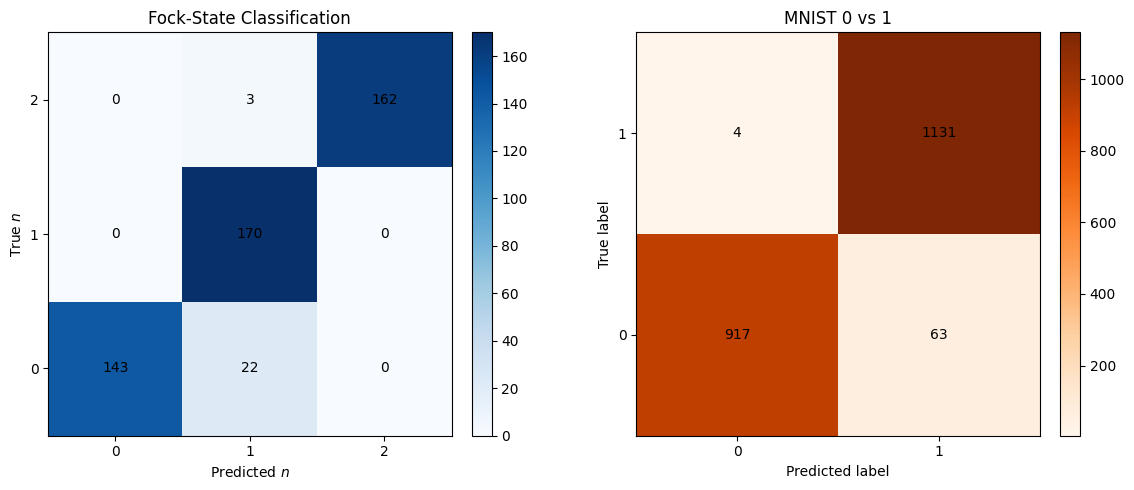

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# --- Prepare data for Fock confusion matrix ---
trues_f, preds_f = [], []
fock_model.eval()
with torch.no_grad():
    for psi, y in loader_test_f:
        psi = psi.to(device)
        out = fock_model(psi)
        pred = predict_fock(out).cpu().numpy()
        trues_f.append(y.numpy())
        preds_f.append(pred)
trues_f = np.concatenate(trues_f)
preds_f = np.concatenate(preds_f)
cm_f = confusion_matrix(trues_f, preds_f, labels=np.arange(max_fock+1))

# --- Prepare data for MNIST confusion matrix ---
trues_m, preds_m = [], []
mnist_model.eval()
with torch.no_grad():
    for X, y in loader_test_m:
        X = X.to(device)
        out = mnist_model(X)
        pred   = predict_mnist(out).cpu().numpy()
        true01 = ((y.numpy() + 1) // 2)    # map {-1,+1}→{0,1}
        preds_m.append(pred)
        trues_m.append(true01)
trues_m = np.concatenate(trues_m)
preds_m = np.concatenate(preds_m)
cm_m = confusion_matrix(trues_m, preds_m, labels=[0,1])

# --- Plot side‐by‐side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Fock‐state confusion
im1 = ax1.imshow(cm_f, origin='lower', cmap='Blues', interpolation='nearest')
ax1.set_title('Fock‐State Classification')
ax1.set_xlabel('Predicted $n$')
ax1.set_ylabel('True $n$')
ticks_f = np.arange(max_fock+1)
ax1.set_xticks(ticks_f)
ax1.set_yticks(ticks_f)
for i in ticks_f:
    for j in ticks_f:
        ax1.text(j, i, cm_f[i, j], ha='center', va='center', color='black')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# MNIST confusion
im2 = ax2.imshow(cm_m, origin='lower', cmap='Oranges', interpolation='nearest')
ax2.set_title('MNIST 0 vs 1')
ax2.set_xlabel('Predicted label')
ax2.set_ylabel('True label')
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
for i in [0,1]:
    for j in [0,1]:
        ax2.text(j, i, cm_m[i, j], ha='center', va='center', color='black')
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('combined_confusion_matrices.png')
plt.show()
